Importing and Preprocessing Datasets

In [53]:
import pandas as pd

test_data = pd.read_csv('sentiment-topic-test.tsv', sep='\t')
test_data.drop('sentence_id', axis=1, inplace=True)
print(test_data.head())

                                            sentence sentiment   topic
0  The stadium was alive with the roar of the cro...  positive  sports
1  That last-minute goal had me jumping out of my...  positive  sports
2  I couldn’t put the book down; it swept me into...  positive    book
3  The story had its moments, though some parts f...   neutral    book
4  I enjoyed the way the timelines shifted, even ...   neutral    book


In [82]:
sentences = pd.read_csv('stanfordSentimentTreebank\datasetSentences.txt', sep='\t')
sentiments = pd.read_csv('stanfordSentimentTreebank\sentiment_labels.txt', sep='|', engine='python')
sentiments.columns = ['sentence_index', 'sentiment_value']

train_data_stf = pd.merge(sentences, sentiments, on='sentence_index')
train_data_stf = train_data_stf.rename(columns={'sentence': 'text', 'sentiment_value': 'rating'})
train_data_stf.drop('sentence_index', axis=1, inplace=True)
train_data_stf['dataset'] = 'stanfordSentimentTreebank'

train_data_stf['rating'] = (train_data_stf['rating'] * 5).clip(0, 5)

def rating_to_sentiment(rating):
    if rating >= 2.8:
        return 'positive'
    elif rating <= 2.2:
        return 'negative'
    else:
        return 'neutral'
    
train_data_stf['sentiment'] = train_data_stf['rating'].apply(rating_to_sentiment)
'''
to_dropp = train_data_stf[train_data_stf['sentiment'] == 'positive'].index[:114]
train_data_stf = train_data_stf.drop(index=to_dropp)

to_dropp = train_data_stf[train_data_stf['sentiment'] == 'negative'].index[:17]
train_data_stf = train_data_stf.drop(index=to_dropp)

to_dropp = train_data_stf[train_data_stf['sentiment'] == 'neutral'].index[:224]
train_data_stf = train_data_stf.drop(index=to_dropp)
'''
train_data_stf.to_csv("stf_dataset.csv", index=False)

print(train_data_stf.shape)
print(train_data_stf['sentiment'].value_counts())

(11855, 4)
sentiment
neutral     5032
positive    3449
negative    3374
Name: count, dtype: int64


In [83]:
from datasets import load_dataset

dataset = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023", 
    "raw_review_Books", 
    split="full[:100000]", 
    trust_remote_code=True
    )

df = pd.DataFrame(dataset)
train_data = df[['rating', 'text']]
train_data['dataset'] = 'amazonReviews'


def rating_to_sentiment(rating):
    if rating == 4.0 or rating == 5.0:
        return 'positive'
    elif rating == 1.0 or rating == 2.0:
        return 'negative'
    else:
        return 'neutral'

train_data['sentiment'] = train_data['rating'].apply(rating_to_sentiment)

print("Original rating distribution:")
print(train_data['sentiment'].value_counts().sort_index())

min_count = train_data['sentiment'].value_counts().min()
print(f"\nMinimum count: {min_count}")

train_data_amazon = train_data.groupby('sentiment').apply(
    lambda x: x.sample(n=min_count, random_state=42)
).reset_index(drop=True)

print(f"\nBalanced sentiment distribution:")
print(train_data_amazon['sentiment'].value_counts().sort_index())
print(f"\nOriginal dataset size: {len(train_data)}")
print(f"Balanced dataset size: {len(train_data_amazon)}")
train_data_amazon.to_csv("amazon_dataset.csv", index=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13724\1420296558.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['dataset'] = 'amazonReviews'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13724\1420296558.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sentiment'] = train_data['rating'].apply(rating_to_sentiment)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13724\1420296558.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depre

Original rating distribution:
sentiment
negative     6439
neutral     10006
positive    83555
Name: count, dtype: int64

Minimum count: 6439

Balanced sentiment distribution:
sentiment
negative    6439
neutral     6439
positive    6439
Name: count, dtype: int64

Original dataset size: 100000
Balanced dataset size: 19317


In [94]:
train_data_combined = pd.concat([train_data_amazon, train_data_stf], ignore_index=True)
train_data_combined = train_data_combined.sample(frac=1, random_state=42).reset_index(drop=True)
print(train_data_combined.head())
print(train_data_combined.shape)
print(train_data_combined['sentiment'].value_counts())

train_data_combined.to_csv("new_dataset_combined.csv", index=False)

   rating                                               text        dataset  \
0     2.0  Super religious so a miss for me.  If I had du...  amazonReviews   
1     5.0  Interesting story line and characters are easy...  amazonReviews   
2     5.0  I was looking for a good book to read, and I g...  amazonReviews   
3     4.0  A beautifully bound Book about curious Cats, d...  amazonReviews   
4     5.0  Home Depots construction books are always good...  amazonReviews   

  sentiment  
0  negative  
1  positive  
2  positive  
3  positive  
4  positive  
(31172, 4)
sentiment
neutral     11471
positive     9888
negative     9813
Name: count, dtype: int64


   rating                                               text sentiment
0     1.0  The premise of this book was a good one. A boo...  negative
1     5.0  Simply and eloquently articulates the tangled ...  positive
2     5.0  Janet Stevens is a wonderful illustrator.  Whe...  positive
3     5.0  The film makes a tragic error by going on for ...  positive
4     5.0  and your reward will be a thoughtful , emotion...  positive


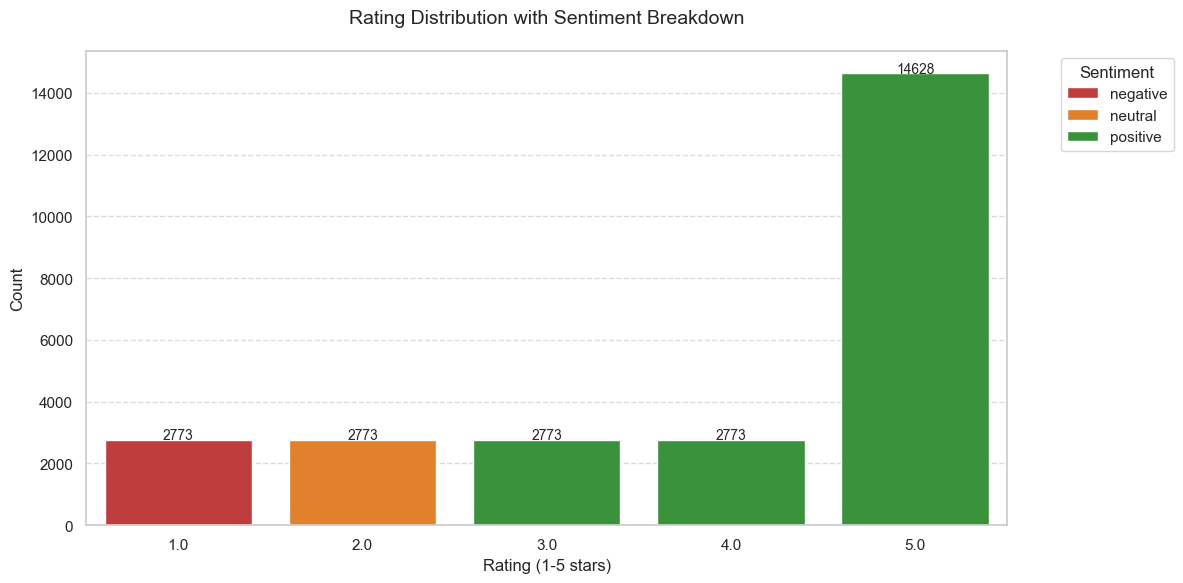

In [89]:
dataset = pd.read_csv("dataset_combined.csv")
print(dataset.head())

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create color mapping
palette = {'negative': '#d62728', 'neutral': '#ff7f0e', 'positive': '#2ca02c'}

# Create plot
ax = sns.countplot(data=dataset, x='rating', hue='sentiment', palette=palette)

# Customize plot
plt.title('Rating Distribution with Sentiment Breakdown', fontsize=14, pad=20)
plt.xlabel('Rating (1-5 stars)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 5,
                f'{int(height)}',
                ha="center", fontsize=10)

# Add reference lines and styling
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In [92]:
import pandas as pd

# Undersample positive class to 2500 instances
positive_samples = dataset[dataset['sentiment'] == 'positive']
undersampled_positive = positive_samples.sample(n=2773, random_state=42)

# Get all negative and neutral samples
other_samples = dataset[dataset['sentiment'] != 'positive']

# Combine undersampled positive with original negative/neutral
undersampled_dataset = pd.concat([undersampled_positive, other_samples])

# Verify the new distribution
print("New class distribution:")
print(undersampled_dataset['sentiment'].value_counts())

# Shuffle the dataset
undersampled_dataset = undersampled_dataset.sample(frac=1, random_state=42).reset_index(drop=True)



New class distribution:
sentiment
positive    2773
negative    2773
neutral     2773
Name: count, dtype: int64


In [93]:
undersampled_dataset.to_csv("undersampled_dataset.csv", index=False)